In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from joblib import dump

import xgboost as xgb
from matplotlib.gridspec import GridSpec
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [109]:
df = pd.read_csv("../data/TABLA_ACCIDENTES_22.csv")

df.head()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_13764\696288881.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/TABLA_ACCIDENTES_22.csv")


,ID_ACCIDENTE,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ISLA,ZONA,ZONA_AGRUPADA,...,PRIORI_OTRA,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
0,1,2022,1,6,3,1,0,NaN,1,1,...,999,1,1,6,1,NaN,NaN,1,998,3
1,2,2022,1,5,16,1,1059,NaN,1,1,...,999,1,3,1,3,NaN,NaN,1,998,2
2,3,2022,1,6,21,1,0,NaN,1,1,...,0,1,1,6,2,NaN,NaN,1,998,2
3,4,2022,1,7,12,1,0,NaN,1,1,...,999,1,3,1,3,NaN,NaN,1,998,1
4,5,2022,1,7,12,1,0,NaN,1,1,...,999,1,1,1,1,NaN,NaN,1,998,3


In [110]:
df.shape

(97916, 73)

El Dataframe del que se parte contiene 97916 filas (registros) y 17 columnas (datos distintos)

In [111]:
df.duplicated().sum()

0

No hay filas duplicadas en el Dataset

In [112]:
df.columns

Index(['ID_ACCIDENTE', 'ANYO', 'MES', 'DIA_SEMANA', 'HORA', 'COD_PROVINCIA',
       'COD_MUNICIPIO', 'ISLA', 'ZONA', 'ZONA_AGRUPADA', 'CARRETERA', 'KM',
       'SENTIDO_1F', 'TITULARIDAD_VIA', 'TIPO_VIA', 'TIPO_ACCIDENTE',
       'TOTAL_MU24H', 'TOTAL_HG24H', 'TOTAL_HL24H', 'TOTAL_VICTIMAS_24H',
       'TOTAL_MU30DF', 'TOTAL_HG30DF', 'TOTAL_HL30DF', 'TOTAL_VICTIMAS_30DF',
       'TOTAL_VEHICULOS', 'TOT_PEAT_MU24H', 'TOT_BICI_MU24H',
       'TOT_CICLO_MU24H', 'TOT_MOTO_MU24H', 'TOT_TUR_MU24H', 'TOT_FURG_MU24H',
       'TOT_CAM_MENOS3500_MU24H', 'TOT_CAM_MAS3500_MU24H', 'TOT_BUS_MU24H',
       'TOT_OTRO_MU24H', 'TOT_SINESPECIF_MU24H', 'TOT_PEAT_MU30DF',
       'TOT_BICI_MU30DF', 'TOT_CICLO_MU30DF', 'TOT_MOTO_MU30DF',
       'TOT_TUR_MU30DF', 'TOT_FURG_MU30DF', 'TOT_CAM_MENOS3500_MU30DF',
       'TOT_CAM_MAS3500_MU30DF', 'TOT_BUS_MU30DF', 'TOT_VMP_MU30DF',
       'TOT_OTRO_MU30DF', 'TOT_SINESPECIF_MU30DF', 'NUDO', 'NUDO_INFO',
       'CARRETERA_CRUCE', 'PRIORI_NORMA', 'PRIORI_AGENTE', 'PR

Hay hasta 31 columnas indicando la gravedad del accidente, por lo que lo primero que haremos será agruparlas todas en una donde tan solo se indique la gravedad como leve, grave o mortal.

Lo primero para ello es entender nuestros datos, por ejemplo: 
    
    ¿La columna que indica el número de fallecidos computados a 30 días integra los fallecidos computados a 24 horas o son independientes?
    ¿La columna que indica el número de fallecidos computados a 30 días integra las victimas computadas a 24 horas o son independientes?

In [113]:
print(f"Total de fallecidos registrados en el accidente computados a 24 horas mas que computados a 30 días es: {df.loc[df['TOTAL_MU24H'] > df['TOTAL_MU30DF']].shape[0]} fallecidos \n")

print(f"Total de víctimas registrados en el accidente computados a 24 horas mas que computados a 30 días es: {df.loc[df['TOTAL_VICTIMAS_24H'] > df['TOTAL_VICTIMAS_30DF']].shape[0]} victimas")

Total de fallecidos registrados en el accidente computados a 24 horas mas que computados a 30 días es: 0 fallecidos 

Total de víctimas registrados en el accidente computados a 24 horas mas que computados a 30 días es: 0 victimas


No existe ningun accidente con más fallecidos ni victimas computadas a 24 horas que a 30 días, se asume por tanto, que el registro computado a 30 días ya incluye el de 24 horas.. 


No vamos a eliminar el resto de columnas sobre fallecidos ya que aunque no se vayan a incluir en nuestro modelo pueden ser interesantes para analizar estadísticas.

Otra cuestión parecida a la anterior es si el número de heridos hospitalizados incluye también a los que acabaron muriendo. Este problema es más complicado, ya que si una víctima es hospitalizada y acaba muriendo en los 30 días posteriores es posible que cuente dentro de los dos grupos, no obstante dado que el total de victimas se calcula con la suma de fallecidos, hospitalizados y no hospitalizados, en teoría si alguien acaba falleciendo en el hospital no debería contar como victima hospitalizada ya que sino al hacer la suma estarían contando doble las victimas en estos casos, pero vamos a comprobarlo.

In [114]:
df[['TOTAL_MU24H','TOTAL_MU30DF','TOTAL_HG24H','TOTAL_HG30DF']].loc[df['TOTAL_MU30DF'] > df['TOTAL_HG30DF']]

,TOTAL_MU24H,TOTAL_MU30DF,TOTAL_HG24H,TOTAL_HG30DF
16,1,1,0,0
133,1,1,0,0
196,1,1,0,0
324,0,1,1,0
446,2,2,0,0
...,...,...,...,...
97610,1,1,0,0
97619,1,1,0,0
97622,1,1,0,0
97646,0,1,1,0


Como se puede comprobar hay columnas en las que el número de fallecidos en 30 días supera al de ingresados en el mismo periodo, aunque pudiera ser que fallecieron fuera sin ser ingresados. 

Pero filas como la 16 donde hay dos víctimas, y una falleció en 24 horas y la otra en los 30 días indican que en efecto la columna de fallecidos es independiente de la de hospitalizados en el mismo periodo.

In [115]:
#más hospitalizados en 24 horas que en 30 días
df[['TOTAL_MU24H','TOTAL_MU30DF','TOTAL_HG24H', 'TOTAL_HG30DF','TOTAL_HL24H','TOTAL_HL30DF','TOTAL_VICTIMAS_24H','TOTAL_VICTIMAS_30DF']].loc[df['TOTAL_HG24H'] > df['TOTAL_HG30DF']]

,TOTAL_MU24H,TOTAL_MU30DF,TOTAL_HG24H,TOTAL_HG30DF,TOTAL_HL24H,TOTAL_HL30DF,TOTAL_VICTIMAS_24H,TOTAL_VICTIMAS_30DF
324,0,1,1,0,0,0,1,1
605,0,1,1,0,0,0,1,1
620,0,1,4,3,0,0,4,4
1568,0,1,1,0,2,2,3,3
1763,0,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...
97226,0,1,1,0,0,0,1,1
97229,0,1,1,0,0,0,1,1
97506,0,1,1,0,0,0,1,1
97646,0,1,1,0,0,0,1,1


Es curioso que si que haya algunos casos donde hay más hospitalizados en 24 horas que en 30 días, por lo que a priori parece que en este caso estár hospitalizado en las primeras 24 horas no implica contar como que estuviste hospitalizado en los 30 días posteriores, no obstante hay algunas incoherencias:
- En todos los casos hubo un fallecido en 30 días y ninguno en 24 horas (Cuando solo era una victima)
- Si estuvo hospitalizado menos de 24 horas y no falleció en esas horas cabría pensar que se trata de un accidente leve, pero solo hay 232 casos cuando los accidentes leves deberían ser mayoritarios, además falleció en los siguientes 30 días lo que indica que fue un accidente mortal.

Teoría: Como hemos mencionado anteriormente alguien fallecido en 30 días no será incluido en la columna de hospitalizados en ese periodo ya que generaría un conteo doble en el total de víctimas, no obstante, si será incluido en los hospitalizados en 24 horas ya que eso no genera ningúna incoherencia. Por tanto, los casos que observamos en la tabla anterior son casos donde la victima del accidente fue llevada al hospital de inmediato (Hospitalizado 24 horas), no falleció en las primeras 24 horas pero sí falleció en los siguientes días y lo sacaron de la lista de hospitalizados en 30 días. En estos casos la víctima nunca fallece en las primeras 24 horas porque de hacerlo se le sacaría del número de hospitalizados en ese periodo (y en el siguiente también ya que contaría como fallecido).

Vamos a confirmar esta teoría, para ello se tienen que dar varias condiciones, que son:

- 1º Si el número de fallecidos en 24 horas es 0 y el número de fallecidos en 30 días es igual al de ingresados en 24 horas y mayor a 0, el número de ingresados en 30 días nunca podrá ser ni igual ni mayor al de fallecidos en 30 días.

In [116]:
# 1º Condición
df[['TOTAL_MU24H','TOTAL_MU30DF','TOTAL_HG24H', 'TOTAL_HG30DF','TOTAL_VICTIMAS_24H',
       'TOTAL_VICTIMAS_30DF','TOTAL_HL24H','TOTAL_HL30DF']].loc[(df['TOTAL_MU24H'] == 0) & (df['TOTAL_MU30DF']==df['TOTAL_HG24H']) & (df['TOTAL_MU30DF']>0) & (df['TOTAL_HG30DF']>=df['TOTAL_MU30DF'])].shape[0]


0

- 2º En los casos donde el número de fallecidos computados a 24 horas y 30 días sea el mismo, y el número de ingresados computados a 24 horas y 30 días también lo sea, serán siempre casos en donde hubo más de una víctima (al menos una que falleció y una que sobrevivió) 

In [117]:
#2º Condición
df[['TOTAL_MU24H','TOTAL_MU30DF','TOTAL_HG24H', 'TOTAL_HG30DF','TOTAL_VICTIMAS_24H',
       'TOTAL_VICTIMAS_30DF']].loc[(df['TOTAL_MU24H'] == df['TOTAL_MU30DF']) & (df['TOTAL_HG24H']==df['TOTAL_MU30DF']) & (df['TOTAL_HG24H']==1)]


,TOTAL_MU24H,TOTAL_MU30DF,TOTAL_HG24H,TOTAL_HG30DF,TOTAL_VICTIMAS_24H,TOTAL_VICTIMAS_30DF
975,1,1,1,1,2,2
1303,1,1,1,1,2,2
1324,1,1,1,1,2,2
1332,1,1,1,1,2,2
1379,1,1,1,1,2,2
...,...,...,...,...,...,...
93982,1,1,1,1,2,2
94088,1,1,1,1,4,4
94451,1,1,1,1,2,2
97596,1,1,1,1,2,2


- 3º El total de víctimas en computados a 24 horas y computados a 30 días siempre será el mismo.

In [118]:
#3º Condición
df.loc[df['TOTAL_VICTIMAS_24H'] != df['TOTAL_VICTIMAS_30DF']].shape[0]

print(f"El número total de vitimas computadas a 24 horas diferentes a computadas a 30 dias es: {df.loc[df['TOTAL_VICTIMAS_24H'] != df['TOTAL_VICTIMAS_30DF']].shape[0]} victimas")

El número total de vitimas computadas a 24 horas diferentes a computadas a 30 dias es: 0 victimas


Todas las condiciones se han cumplido, por lo que parece que la teoría planteada era correcta. Además se termina de concluir que los registros computados a 30 días incluyen los computados a 24 horas.

In [119]:
# ALEX: Este creo que no aporta nada pero lo he dejado por si opinas lo contrario, si estás de acuerdo bórralo
df[['TOTAL_MU30DF','TOTAL_HG30DF','TOTAL_HL30DF','TOTAL_VICTIMAS_30DF']].loc[(df['TOTAL_MU30DF'] == df['TOTAL_HG30DF']) & (df['TOTAL_MU30DF'] > 1)]

,TOTAL_MU30DF,TOTAL_HG30DF,TOTAL_HL30DF,TOTAL_VICTIMAS_30DF
12034,2,2,2,6
12851,2,2,0,4
29576,2,2,6,10
30031,2,2,2,6
31432,3,3,0,6
83079,2,2,0,4
88434,2,2,6,10
91138,2,2,0,4


In [120]:
#Eliminamos las columnas redundantes
df = df.drop(['TOTAL_MU24H','TOTAL_VICTIMAS_24H','TOTAL_HL24H'], axis=1)

Diferenciaremos entre tres tipos de accidentes: Mortal, leve y sin lesiones. Ya que en el dataset no se indica el tipo de lesión vamos a establecer el siguiente criterio:

- Mortal = La víctima fallece (en cualquier periodo).
- Leve = Fue al hospital
- Sin lesiones = No fue al hospital

Se establece la columna tipo de accidente en función de la prioridad:

- Si hay una victima mortal, el accidente se clasifica como  'Mortal'
- Si no hay ningun accidente mortal pero al menos una víctima ha sido ingresada en el hospital, el accidente se clasifica como 'Leve'
- Si no hay ningun accidente mortal ni nadie ha sido ingresado en el hospital el accidente se clasifica como 'Sin_lesiones'

In [121]:

def clasificar_accidentes(column):
    if column['TOTAL_MU30DF'] > 0:
        return 'Mortal'
    elif column['TOTAL_HG30DF'] > 0 & column['TOTAL_MU30DF'] == 0: 
        return 'Leve'
    else: 
        return 'Sin_lesiones'

df['TYP_ACC'] = df.apply(clasificar_accidentes, axis=1) # Crear la columna TYP_ACC basada en las condicione

Se contabiliza el número de accidentes mortales, leves y sin lesiones que hay en el dataset

In [122]:
cont_mortales = 0
cont_leves = 0
cont_sin_lesiones = 0

for i in df['TYP_ACC']:
    if i == "Mortal":
        cont_mortales += 1
    elif i == "Leve":
        cont_leves += 1
    else:
        cont_sin_lesiones +=1

total_accidentes = cont_mortales + cont_leves + cont_sin_lesiones #len(df)
porc_mortales = (cont_mortales/total_accidentes)*100
porc_leves = (cont_leves/total_accidentes)*100
porc_sin_lesiones = (cont_sin_lesiones/total_accidentes)*100

print(f"El numero de accidentes mortales es {cont_mortales} un {porc_mortales:.2f}% del total de accidentes\n")
print(f"El número de accidentes leves es {cont_leves} un {porc_leves:.2f}% del total de accidentes \n")
print(f"El número de accidentes sin lesiones es {cont_sin_lesiones} un {porc_sin_lesiones:.2f}% del total de accidentes")


El numero de accidentes mortales es 1620 un 1.65% del total de accidentes

El número de accidentes leves es 7410 un 7.57% del total de accidentes 

El número de accidentes sin lesiones es 88886 un 90.78% del total de accidentes


Se extrae que la gran mayoría de accidentes han sido sin lesiones, una minoria leves y una gran minoria mortales.

# Limpieza y simplificación del Dataset

In [123]:
# Eliminar irrelevantes
df = df.drop(['ID_ACCIDENTE','ZONA_AGRUPADA','ANYO','TITULARIDAD_VIA', 'TOT_PEAT_MU24H','TOT_BICI_MU24H','TOT_CICLO_MU24H',
       'TOT_SINESPECIF_MU24H','TOT_SINESPECIF_MU30DF','NUDO_INFO','CARRETERA_CRUCE','CONDICION_NIEBLA', 'TOT_MOTO_MU24H', 'TOT_TUR_MU24H',
       'TOT_FURG_MU24H','TOT_CAM_MENOS3500_MU24H','TOT_CAM_MAS3500_MU24H', 'TOT_BUS_MU24H','TOT_OTRO_MU24H',
       'CONDICION_VIENTO','SENTIDO_1F','PRIORI_NORMA', 'PRIORI_AGENTE', 'PRIORI_SEMAFORO', 'PRIORI_VERT_STOP',
       'PRIORI_VERT_CEDA', 'PRIORI_HORIZ_STOP', 'PRIORI_HORIZ_CEDA','PRIORI_MARCAS', 'PRIORI_PEA_NO_ELEV', 'PRIORI_PEA_ELEV',
       'PRIORI_MARCA_CICLOS', 'ACERA','TIPO_VIA','VISIB_RESTRINGIDA_POR','CONDICION_NIVEL_CIRCULA','PRIORI_CIRCUNSTANCIAL',
       'PRIORI_OTRA','TRAZADO_PLANTA','COD_MUNICIPIO', 'ISLA'], axis=1)


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97916 entries, 0 to 97915
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MES                       97916 non-null  int64  
 1   DIA_SEMANA                97916 non-null  int64  
 2   HORA                      97916 non-null  int64  
 3   COD_PROVINCIA             97916 non-null  int64  
 4   ZONA                      97916 non-null  int64  
 5   CARRETERA                 97916 non-null  object 
 6   KM                        50944 non-null  float64
 7   TIPO_ACCIDENTE            97916 non-null  int64  
 8   TOTAL_HG24H               97916 non-null  int64  
 9   TOTAL_MU30DF              97916 non-null  int64  
 10  TOTAL_HG30DF              97916 non-null  int64  
 11  TOTAL_HL30DF              97916 non-null  int64  
 12  TOTAL_VICTIMAS_30DF       97916 non-null  int64  
 13  TOTAL_VEHICULOS           97916 non-null  int64  
 14  TOT_PE

Parece que el dataset no tiene valores nulos excepto por la columna 'ISLA' que es normal porque la mayoría de accidentes ocurrieron en el territorio peninsular y en 'KM' que se trata de carreteras no inventariadas. No obstante esto no es cierto ya que en el dataset se utiliza 999 para indicar los valores faltantes, por eso parece que no hay nulos, vamos a eliminar estos valores para ver realmente como es nuestro Dataframe. También vamos a sustituir los valores nulos en 'ISLA' con 0 para indicar que no aplica.

In [125]:
df = df.replace(999, np.nan)
df[['CONDICION_METEO']] = df[['CONDICION_METEO']].replace(7, np.nan)
df[['CONDICION_FIRME']] = df[['CONDICION_FIRME']].replace(9, np.nan)

In [126]:
#Comprobar el número de valores nulos en las columnas ajustadas
df_subset_nulls = df[['CONDICION_METEO','CONDICION_FIRME']]
df_subset_nulls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97916 entries, 0 to 97915
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CONDICION_METEO  96411 non-null  float64
 1   CONDICION_FIRME  96610 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


Aunque hay más nulos que antes, siguen siendo pocos teniendo en cuenta el tamaño del dataset, por la única columna que eliminaremos en base a este criterio es 'KM'

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97916 entries, 0 to 97915
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MES                       97916 non-null  int64  
 1   DIA_SEMANA                97916 non-null  int64  
 2   HORA                      97916 non-null  int64  
 3   COD_PROVINCIA             97916 non-null  int64  
 4   ZONA                      97916 non-null  int64  
 5   CARRETERA                 97916 non-null  object 
 6   KM                        50944 non-null  float64
 7   TIPO_ACCIDENTE            97916 non-null  int64  
 8   TOTAL_HG24H               97916 non-null  int64  
 9   TOTAL_MU30DF              97916 non-null  int64  
 10  TOTAL_HG30DF              97916 non-null  int64  
 11  TOTAL_HL30DF              97916 non-null  int64  
 12  TOTAL_VICTIMAS_30DF       97916 non-null  int64  
 13  TOTAL_VEHICULOS           97916 non-null  int64  
 14  TOT_PE

In [128]:
df[['TYP_ACC','CONDICION_FIRME','CONDICION_METEO']].loc[df['CONDICION_METEO'].isna()].shape[0]

1505

In [129]:
df[['TYP_ACC','CONDICION_FIRME','CONDICION_METEO']].loc[df['CONDICION_METEO'].isna() & (df['TYP_ACC']!= 'Sin_lesiones')].shape[0]

114

Hay 1505 filas que contienen valores nulos en la variable meteorológia que practicamente coinciden con los valores nulos en la variable sobre la condicion del firme. Dada la extensión de nuestro dataset parece razonable eliminar estas filas, por descgracia contienen también 114 accidentes que no fueron "Sin_lesiones", no obstante se considerá que es mejor eliminar estos valores nulos del dataset ya que aunque estemos faltos de muestras con accidentes graves y leves, estamos eliminando 10 veces más de los accidentes "Sin_lesiones", aunque en proporción es practicamente lo mismo por lo que no va a cambiar practicamente el dataset

In [130]:
df = df.dropna(subset=['CONDICION_METEO', 'CONDICION_FIRME'])

In [131]:
#Eliminamos esta columna por tener tantos valores nulos
df = df.drop(['KM'], axis=1)

# Simplificación de las variables

Hay ciertas variables que aunque son categóricas como la provincia, el tipo de vía, el tipo de accidente, etc. Se encuentran en formato numérico, lo cual para entrenar el modelo será mejor pero para visualizar los datos puede ser muy confuso, por lo que vamos a crear diccionarios de todas ellas para ayudar visualizar los datos.

In [132]:
#Diccionarios
mes = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'}

dia_semana = {1:'Lunes', 2:'Martes', 3:'Miércoles', 4:'Jueves', 5:'Viernes', 6:'Sábado', 7:'Domingo'}

cod_provincia = {1: 'Álava', 2: 'Albacete', 3: 'Alicante', 4: 'Almería', 5: 'Ávila', 6: 'Badajoz', 7: 'Islas Baleares', 8: 'Barcelona', 
                9: 'Burgos', 10: 'Cáceres', 11: 'Cádiz', 12: 'Castellón', 13: 'Ciudad Real', 14: 'Córdoba', 15: 'Coruña', 16: 'Cuenca', 
                17: 'Girona', 18: 'Granada', 19: 'Guadalajara', 20: 'Gipuzkoa', 21: 'Huelva', 22: 'Huesca', 23: 'Jaén', 24: 'León', 
                25: 'Lleida', 26: 'Rioja, La', 27: 'Lugo', 28: 'Madrid', 29: 'Málaga', 30: 'Murcia', 31: 'Navarra', 32: 'Ourense', 
                33: 'Asturias', 34: 'Palencia', 35: 'Las Palmas', 36: 'Pontevedra', 37: 'Salamanca', 38: 'Santa Cruz de Tenerife', 
                39: 'Cantabria', 40: 'Segovia', 41: 'Sevilla', 42: 'Soria', 43: 'Tarragona', 44: 'Teruel', 45: 'Toledo', 46: 'Valencia', 
                47: 'Valladolid', 48: 'Bizkaia', 49: 'Zamora', 50: 'Zaragoza', 51: 'Ceuta', 52: 'Melilla'}

zona = {1:'Carretera',2:'Travesía',3:'Calle',4:'Autopista o autovía urbana'}
#Me equivoqué, estos diccionarios no hacen falta, necesitamos ponerlos con las nuevas variables
tipo_accidente={1:'Colisión',2:'Atropello',3:'Salida de la vía',4:'Otros tipos de accidente'}

interseccion = {1:'En intersección', 2:'Fuera de intersección'}

condicion_meteo = {1:'Despejado',2:'Nublado',3:'Lluvia débil',4:'Lluvia fuerte',5:'Granizando',6:'Nevando'}

condicion_firme={1:'Seco y limpio',2:'Con barro o gravilla suelta',3:'Mojado',4:'Hielo',8:'Otra'}

condicion_iluminacion={1:'Luz del día natural',2:'Amanecer o atardecer',3:'Sin luz natural'}

Debido a que más del 90% de accidentes se agrupan en la categoría 'Sin_lesiones' es necesario simplificar las variables con demasiadas categorías ya que sino cada accidente con leve o grave va a tener características únicas, dificultando enormemente tanto el analisis de los datos como el entrenamiento del modelo

In [133]:
#diccionarios para simplificar las variables
tipo_accidente_simpl = {1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:2, 8:2, 11:3, 12:3, 13:3, 14:3, 15:3, 16:3, 17:3, 18:3, 19:3, 9:4, 10:4, 20:4}
condicion_firme_simpl = {1:1, 2:2, 3:3, 4:3, 5:4, 6:4, 7:4, 8:5}
condicion_iluminacion_simpl = {1:1, 2:2, 3:2,4:3, 5:3, 6:3}

#Actualización con las nuevas variables
df['TIPO_ACCIDENTE'] = df['TIPO_ACCIDENTE'].map(tipo_accidente_simpl)
df['CONDICION_FIRME'] = df['CONDICION_FIRME'].map(condicion_firme_simpl)
df['CONDICION_ILUMINACION'] = df['CONDICION_ILUMINACION'].map(condicion_iluminacion_simpl)


In [134]:
#Agrupación de provincias en comunidades autónomas
dict_prov_to_com={1:'País Vasco',2:'Castilla-La Mancha',3:'Comunidad Valenciana',4:'Andalucía',5:'Castilla y León',6:'Extremadura',
                  7:'Islas Baleares',8:'Cataluña',9:'Castilla y León',10:'Extremadura',11:'Andalucía',12:'Comunidad Valenciana',
                  13:'Castilla-La Mancha',14:'Andalucía',15:'Galicia',16:'Castilla-La Mancha',17:'Cataluña',18:'Andalucía',
                  19:'Castilla-La Mancha',20:'País Vasco',21:'Andalucía',22:'Aragón',23:'Andalucía',24:'Castilla y León',25:'Cataluña',
                  26:'La Rioja',27:'Galicia',28:'Comunidad de Madrid',29:'Andalucía',30:'Murcia',31:'Navarra',32:'Galicia',33:'Asturias',
                  34:'Castilla y León',35:'Islas Canarias',36:'Galicia',37:'Castilla y León',38:'Islas Canarias',39:'Cantabria',
                  40:'Castilla y León',41:'Andalucía',42:'Castilla y León',43:'Cataluña',44:'Aragón',45:'Castilla-La Mancha',
                  46:'Comunidad Valenciana',47:'Castilla y León',48:'País Vasco',49:'Castilla y León',50:'Aragón',51:'Ceuta',52:'Melilla'}

df['COMUNIDAD'] = df['COD_PROVINCIA'].map(dict_prov_to_com)

In [135]:
#Cambio de nombre columnas para evitar confusión
df.rename(columns={'TIPO_ACCIDENTE': 'MECANISMO_ACCIDENTE'}, inplace=True)
df.rename(columns={'CONDICION_FIRME': 'CONDICION_SUELO'}, inplace=True)
df.rename(columns={'NUDO': 'INTERSECCION'}, inplace=True)

Por último vamos a crear una dataframe alternativo orientado al análisis de los datos y el original con los datos en formato numérico para el entrenamiento del modelo principalmente

In [136]:
df_eda = df.copy()

df_eda['MES'] = df_eda['MES'].map(mes)
df_eda['DIA_SEMANA'] = df_eda['DIA_SEMANA'].map(dia_semana)
df_eda['PROVINCIA'] = df_eda['COD_PROVINCIA'].map(cod_provincia)
df_eda['ZONA'] = df_eda['ZONA'].map(zona)
df_eda['MECANISMO_ACCIDENTE'] = df_eda['MECANISMO_ACCIDENTE'].map(tipo_accidente)
df_eda['INTERSECCION'] = df_eda['INTERSECCION'].map(interseccion)
df_eda['CONDICION_METEO'] = df_eda['CONDICION_METEO'].map(condicion_meteo)
df_eda['CONDICION_SUELO'] = df_eda['CONDICION_SUELO'].map(condicion_firme)
df_eda['CONDICION_ILUMINACION'] = df_eda['CONDICION_ILUMINACION'].map(condicion_iluminacion)

# Análisis de los datos

Lo primero de todo vamos a analizar la influencia de todas las variables con una matriz de correlación para ir de lo feneral a lo específico.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_13764\3619694738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["TYP_ACC"] = pd.factorize(df_subset["TYP_ACC"])[0]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_13764\3619694738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["COMUNIDAD"] = pd.factorize(df_subset["COMUNIDAD"])[0]


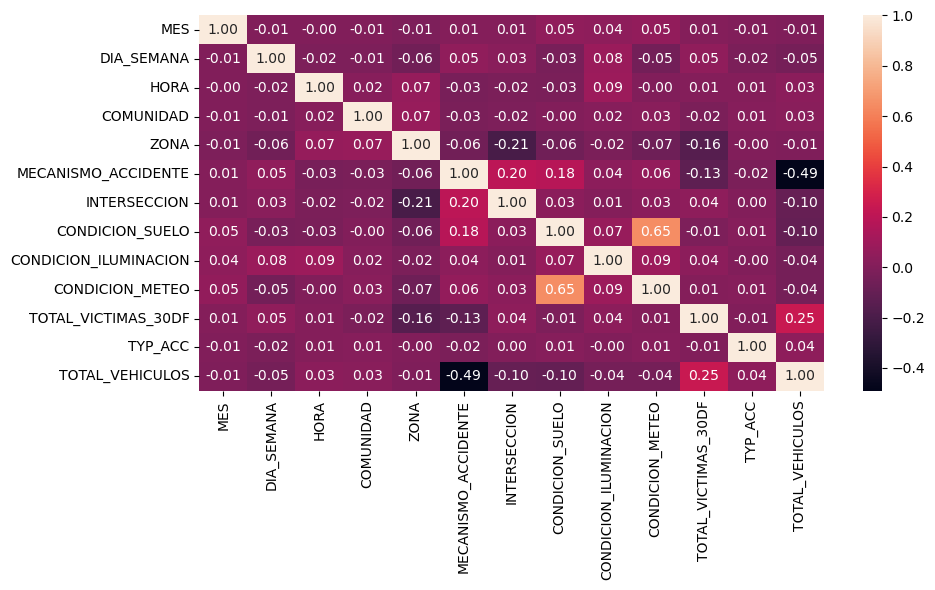

In [137]:
df_subset = df[['MES', 'DIA_SEMANA', 'HORA', 'COMUNIDAD','ZONA','MECANISMO_ACCIDENTE','INTERSECCION', 
            'CONDICION_SUELO', 'CONDICION_ILUMINACION','CONDICION_METEO','TOTAL_VICTIMAS_30DF', 'TYP_ACC', 'TOTAL_VEHICULOS']]
#Necesitamos convertir primero la variables categóricas a numéricas
df_subset["TYP_ACC"] = pd.factorize(df_subset["TYP_ACC"])[0]
df_subset["COMUNIDAD"] = pd.factorize(df_subset["COMUNIDAD"])[0]

#Crear la matriz
fig, axis = plt.subplots(figsize = (10, 6))

sns.heatmap(df_subset.corr(), annot = True, fmt = ".2f")
plt.tight_layout()
plt.show()

Lo primero que se observa es la nula influencia de todas las variables en el tipo de accidente, esto era de esperar dado lo exageradamente poblado que está el dataset de accidentes tipo 'Sin Lesiones', por tanto, este primer análisis no concluye que las variables dependientes son incapaces de predecir la variable dependiente, sino que se requiere de más técnicas y un análisis más profundo.

Respecto a la relación entre variables dependientes, la más fuerte es entre la condicion del suelo y las condiciones meteorológicas, casi un 70% de correlación, además el mecanismo del accidente parece relacionarse bastante con si se da en una intersección o no.
El mecanismo del accidente y la intersección tienen alrededor de un 20% de correlación con la zona, que tiene también un 13% de correlación con el número de víctimas del accidente. No obstante, la mayor relación del mecanismo del accidente se da con la variable del total de vehículos implicados en el mismo con casi un 50% de correlación.

Por último, como cabría esperar el total de víctimas está relacionado con el total de vehículos por un 25%.

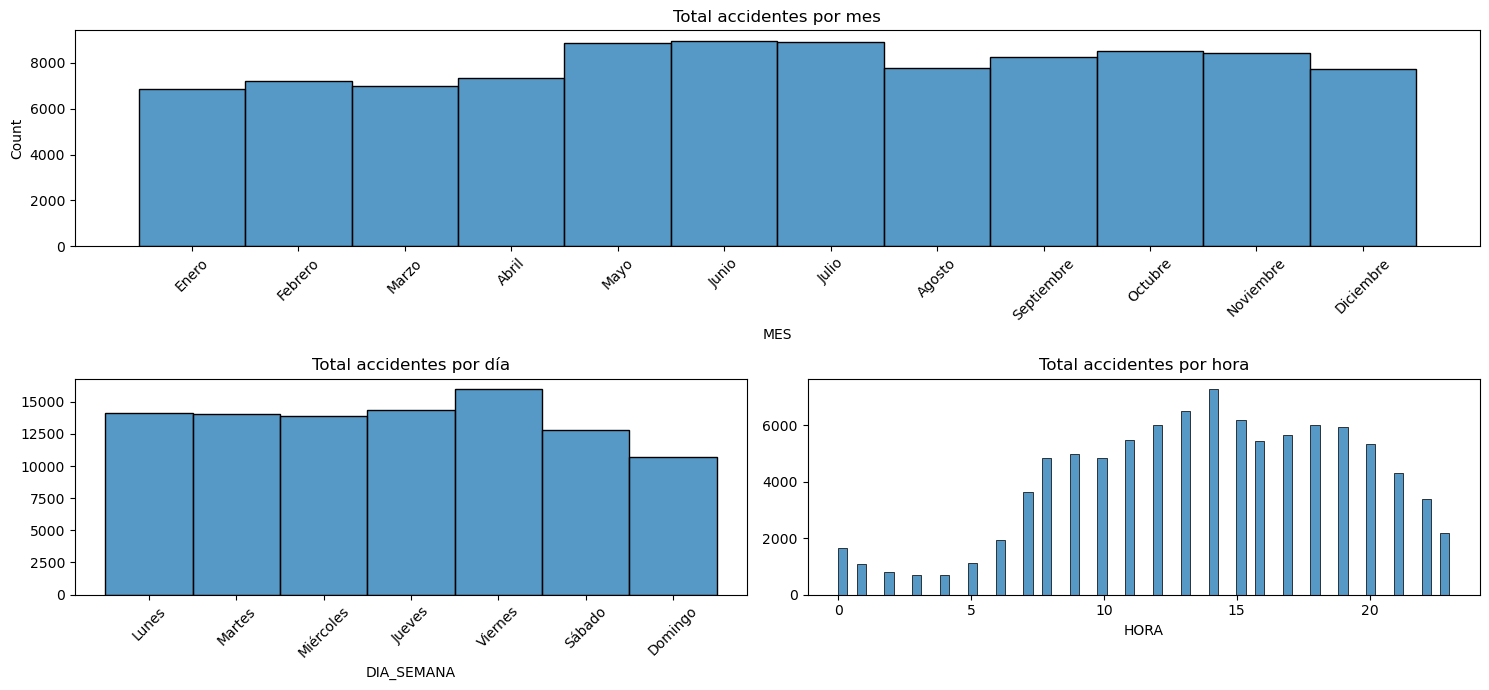

In [138]:
#Relación entre la fecha y los accidentes

dias_ordenados = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df_eda['DIA_SEMANA'] = pd.Categorical(df_eda['DIA_SEMANA'], categories=dias_ordenados, ordered=True)


fig = plt.figure(figsize=(15, 7))
gs = GridSpec(2, 2, figure=fig)
ax_mes = fig.add_subplot(gs[0, :])      # Ocupa toda la primera fila
ax_dia = fig.add_subplot(gs[1, 0])      # Segunda fila, primera columna
ax_hora = fig.add_subplot(gs[1, 1])     # Segunda fila, segunda columna

sns.histplot(data=df_eda, x='MES', ax=ax_mes)
ax_mes.tick_params(axis='x', rotation=45)
ax_mes.set_title('Total accidentes por mes')
#Ordenar columna dias de la semana
sns.histplot(data=df_eda, x='DIA_SEMANA', ax=ax_dia).set(ylabel=None)
ax_dia.tick_params(axis='x', rotation=45)
ax_dia.set_title('Total accidentes por día')
ax_hora.set_title('Total accidentes por hora')
sns.histplot(data=df_eda, x='HORA', ax=ax_hora).set(ylabel=None)

plt.tight_layout()
plt.show()

Los accidentes son relativamente constantes, pero los 4 primeros meses del año se mantienen más bajos (~6000). Los meses de Mayo a Julio suben de manera abrupta pasándo de largo los 8000 incidentes por mes. Es probable que se deba a que en España exista un elevado número de días festivos durante estos meses. El resto del año se mantienen en un punto medio alrededor de 8000.

Respecto a los días de la semana entre diario se mantienen bastante constantes pero suben los viernes que es el día de más accidentes, suponemos que se debe a que la gente sale más de fiesta ese día y que se toma más alcohol. Los domingos al contrario es el día que menos accidentes hay ya que probablemente también sea el día que menos se coge el coche. Lo que resulta curioso de este gráfico es que el número de accidentes es bastante constante siempre, la diferencia entre el día que más accidentes se producen y el que menos no es ni del 50%, esperábamos tendencias mucho más marcadas. Tal vez si miramos el tipo de accidentes o el número de víctimas si que veamos tendencias más marcadas.

La hora si presenta mayores tendencias. Las horas de la madrugada son las que menos accidentes tienen a pesar de que probablemente sea cuando los conductores están más cansados o bajo más sustancias, el considerable menor número de vehículos circulando a esa pesa demasiado en este gráfico, si tuviesemos los datos del número aproximado de vehículos circulando podríamos observar mejor si existe una mayor probabilidad de tener un accidente a esas horas. 
El mayor número de accidentes se produce a las 14:00, esto se debe a que a esa hora es hora punta, pero seguramente la mayoría de esos accidentes sean pequeños golpes y seguramente el número de accidentes mortales a esa hora no es muy alto, pero lo comprobaremos más adelante. Sorprendentemente las 18 que es la hora pico en España no es la que más accidentes tiene. Creo que este gráfico está demasiado influenciado por la densidad de tráfico a ciertas horas como para poder sacar mayores conclusiones.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_13764\1065527774.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_dia = df_mortal.groupby('DIA_SEMANA').size().reset_index(name='Num_Accidentes')


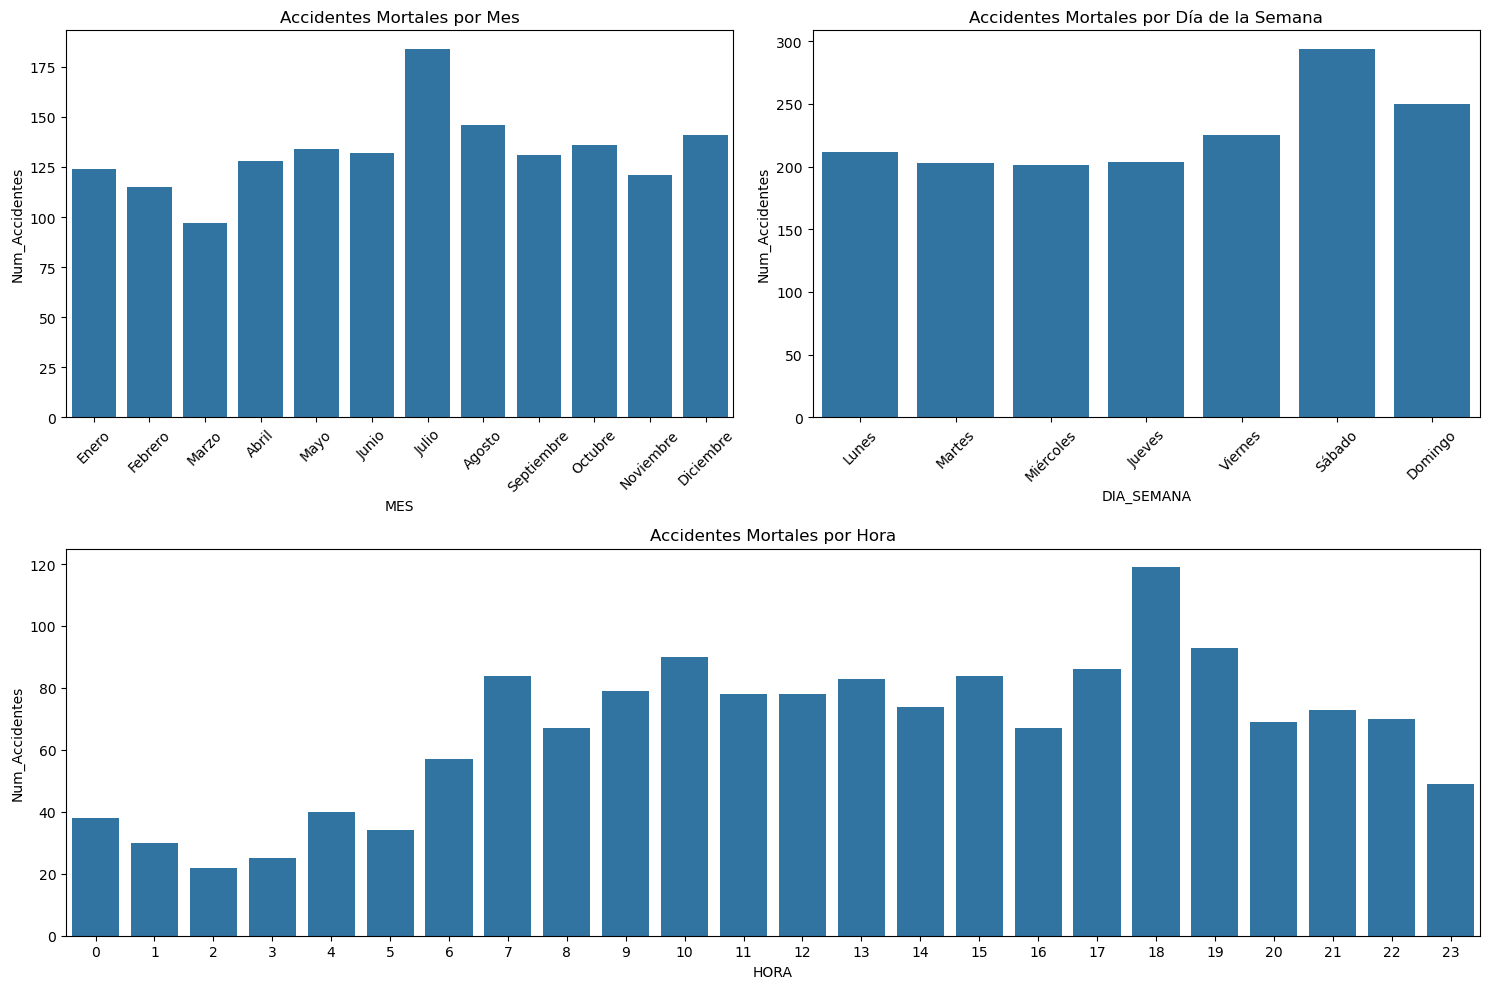

In [139]:
#Cantidad de accidentes graves y mortales en función de la fecha
df_mortal = df_eda[df_eda['TYP_ACC'] == 'Mortal']

# Agrupamos por variable + conteo
acc_mes = df_mortal.groupby('MES').size().reset_index(name='Num_Accidentes')
ordered_months = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto',
                  'Septiembre','Octubre','Noviembre','Diciembre']
acc_mes['MES'] = pd.Categorical(acc_mes['MES'], categories=ordered_months, ordered=True)
acc_mes = acc_mes.sort_values('MES')

acc_dia = df_mortal.groupby('DIA_SEMANA').size().reset_index(name='Num_Accidentes')
ordered_days = ['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']
acc_dia['DIA_SEMANA'] = pd.Categorical(acc_dia['DIA_SEMANA'], categories=ordered_days, ordered=True)
acc_dia = acc_dia.sort_values('DIA_SEMANA')

acc_hora = df_mortal.groupby('HORA').size().reset_index(name='Num_Accidentes')
acc_hora = acc_hora.sort_values('HORA')

# Configurar el gráfico
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax_mes = fig.add_subplot(gs[0, 0])
ax_dia = fig.add_subplot(gs[0, 1])
ax_hora = fig.add_subplot(gs[1, :])

sns.barplot(ax=ax_mes, data=acc_mes, x='MES', y='Num_Accidentes')
ax_mes.set_title('Accidentes Mortales por Mes')
ax_mes.tick_params(axis='x', rotation=45)

sns.barplot(ax=ax_dia, data=acc_dia, x='DIA_SEMANA', y='Num_Accidentes')
ax_dia.set_title('Accidentes Mortales por Día de la Semana')
ax_dia.tick_params(axis='x', rotation=45)

sns.barplot(ax=ax_hora, data=acc_hora, x='HORA', y='Num_Accidentes')
ax_hora.set_title('Accidentes Mortales por Hora')
ax_hora.tick_params(axis='x')

plt.tight_layout()
plt.show()

Lo primero que se observa en las gráficas de Mes y Día es la mayor variabilidad respecto a las gráficas anteriores, el mes de Julio sobresale del resto como el mes con más fallecidos, esto podría deberse a que se trata del mes donde más gente coge las vacaciones de verano y aunque pueda existir menor congestión de tráfico en las ciudades, se usa más en ambiente de fiesta y hay más congestión en las salidas de las ciudades donde la velocidad a la que se circula es mucho mayor incrementando la letalidad de los accidentes.

Respecto al gráfico de los días es curiosos que los dos días con menor número total de accidentes (Sábado y Domingo), sean también los días con mayor número de accidentes mortales. Esto tiene mucho sentido ya que en efecto hay menor tráfico en ciudad por lo que hay menor número de accidentes en total, no obstante la gente usa el coche en entornos con más alcohol (la gente que salga el viernes regresará en coche la madrugada del Sábado) y en salidas de la ciudad donde la circulación es a mayor velocidad que en vías interurbanas.

En el gráfico de horas ocurre lo contrario que en los otros dos, se observa menor variabilidad en comparación con el gráfico anterior. En el gráfico anterior las 4 era una de las horas con menos accidentes, habiendo aproximandamente 7 veces menos que a la hora pico, ahora, la diferencia es de solo 3 veces. Por supuesto las horas de la madrugada son horas con pocos accidentes mortales en comparación con horas pico pero esto confirma nuestras sospechas de que a esas horas hay mayor probabilidad de que un accidente sea mortal no obstante vamos a terminar de confirmarlo con un tercer gráfico. Las 18 es la hora pico de fallecidos coincidiendo con la hora a la que la mayoría de las personas salen del trabajo, imaginamos que el mayor número de victimas mortales se debe a que muchos accidentes ocurren en los tramos entre ciudades pero esto aún requiere mayor análisis.

Como hemos mencionado sería interesante tener una variable indicando el total de coches en circulación en cada accidente, aunque no disponemos de ella una aproximación bastante fiable es usar el número total de accidentes en un periodo como indicador del volumen de tráfico en ese mismo periodo, esto nos servirá para poder normalizar los datos y compararlos.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_13764\229846250.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = df_eda.groupby(['MES', 'DIA_SEMANA', 'HORA']).size().reset_index(name='Total_Accidentes')
C:\Users\Carlos\AppData\Local\Temp\ipykernel_13764\229846250.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortal = df_eda[df_eda['TYP_ACC'] == 'Mortal'].groupby(['MES', 'DIA_SEMANA', 'HORA']).size().reset_index(name='Accidentes_Mortales')
C:\Users\Carlos\AppData\Local\Temp\ipykernel_13764\229846250.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a 

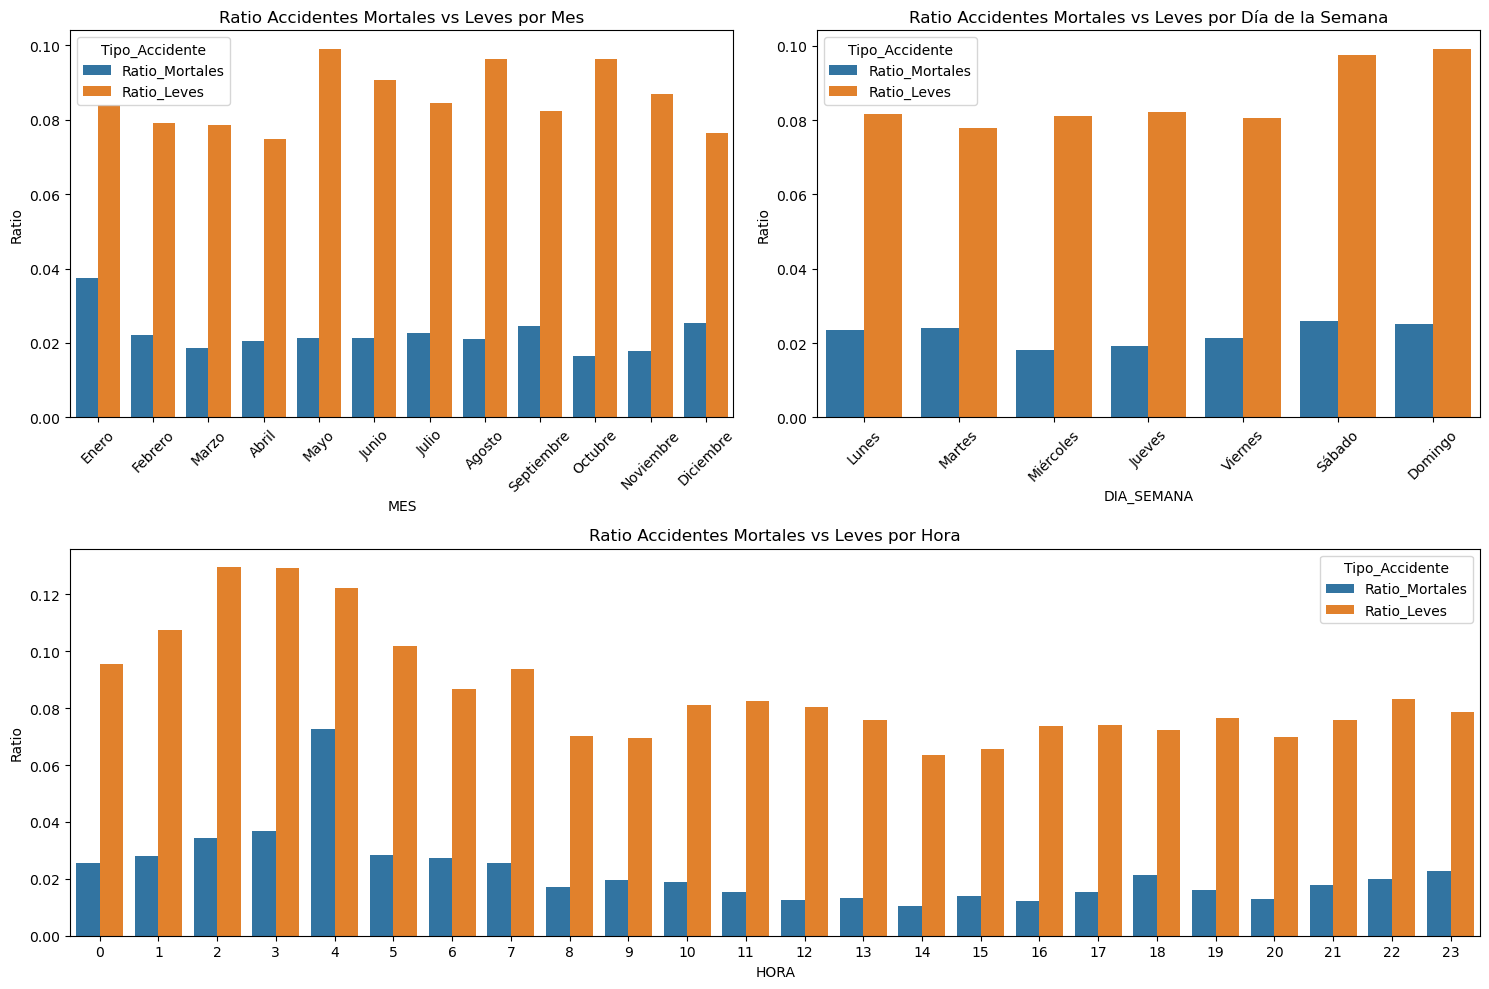

In [140]:
# Total de accidentes por MES, DIA_SEMANA y HORA
total = df_eda.groupby(['MES', 'DIA_SEMANA', 'HORA']).size().reset_index(name='Total_Accidentes')

# Accidentes mortales y leves
mortal = df_eda[df_eda['TYP_ACC'] == 'Mortal'].groupby(['MES', 'DIA_SEMANA', 'HORA']).size().reset_index(name='Accidentes_Mortales')
leve = df_eda[df_eda['TYP_ACC'] == 'Leve'].groupby(['MES', 'DIA_SEMANA', 'HORA']).size().reset_index(name='Accidentes_Leves')

# Unimos los datos
datos_fecha = pd.merge(total, mortal, on=['MES', 'DIA_SEMANA', 'HORA'], how='left')
datos_fecha = pd.merge(datos_fecha, leve, on=['MES', 'DIA_SEMANA', 'HORA'], how='left')

# Calcular los ratios
datos_fecha['Ratio_Mortales'] = datos_fecha['Accidentes_Mortales'] / datos_fecha['Total_Accidentes']
datos_fecha['Ratio_Leves'] = datos_fecha['Accidentes_Leves'] / datos_fecha['Total_Accidentes']

# Ordenar MES y DIA_SEMANA
datos_fecha['MES'] = pd.Categorical(datos_fecha['MES'], categories=ordered_months, ordered=True)
datos_fecha = datos_fecha.sort_values('MES')

datos_fecha['DIA_SEMANA'] = pd.Categorical(datos_fecha['DIA_SEMANA'], categories=ordered_days, ordered=True)
datos_fecha = datos_fecha.sort_values('DIA_SEMANA')

datos_mes = datos_fecha.groupby('MES').agg({'Ratio_Mortales':'mean', 'Ratio_Leves':'mean'}).reset_index()
datos_mes_long = pd.melt(datos_mes, id_vars='MES', value_vars=['Ratio_Mortales', 'Ratio_Leves'], 
                         var_name='Tipo_Accidente', value_name='Ratio')

datos_dia = datos_fecha.groupby('DIA_SEMANA').agg({'Ratio_Mortales':'mean', 'Ratio_Leves':'mean'}).reset_index()
datos_dia_long = pd.melt(datos_dia, id_vars='DIA_SEMANA', value_vars=['Ratio_Mortales', 'Ratio_Leves'], 
                         var_name='Tipo_Accidente', value_name='Ratio')

datos_hora = datos_fecha.groupby('HORA').agg({'Ratio_Mortales':'mean', 'Ratio_Leves':'mean'}).reset_index()
datos_hora_long = pd.melt(datos_hora, id_vars='HORA', value_vars=['Ratio_Mortales', 'Ratio_Leves'], 
                          var_name='Tipo_Accidente', value_name='Ratio')

#Graficar
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)

# Gráfico por MES
ax_mes = fig.add_subplot(gs[0, 0])
sns.barplot(ax=ax_mes, data=datos_mes_long, x='MES', y='Ratio', hue='Tipo_Accidente', errorbar=None)
ax_mes.set_title('Ratio Accidentes Mortales vs Leves por Mes')
ax_mes.tick_params(axis='x', rotation=45)

# Gráfico por DIA_SEMANA
ax_dia = fig.add_subplot(gs[0, 1])
sns.barplot(ax=ax_dia, data=datos_dia_long, x='DIA_SEMANA', y='Ratio', hue='Tipo_Accidente', errorbar=None)
ax_dia.set_title('Ratio Accidentes Mortales vs Leves por Día de la Semana')
ax_dia.tick_params(axis='x', rotation=45)

# Gráfico por HORA
ax_hora = fig.add_subplot(gs[1, :])
sns.barplot(ax=ax_hora, data=datos_hora_long, x='HORA', y='Ratio', hue='Tipo_Accidente', errorbar=None)
ax_hora.set_title('Ratio Accidentes Mortales vs Leves por Hora')
ax_hora.tick_params(axis='x')

plt.tight_layout()
plt.show()

Este gráfico es el más ilustrativo de los tres ya que permite hacer una comparativa más justa, y nos dice el ratio entre accidentes mortales y el total de accidentes.

El gráfico que más cambia respecto a los anteriores es el de las horas, que practicamente se ha invertido, ahora se observa como un accidente en las horas de la madrugada son potencialemente más peligrosos siendo el pico a las 4, donde la probabilidad de que un accidente sea mortal es de alrededor de un 18%. Este gráfico también demuestra que la hora tiene una clara correlación con el tipo de accidente.

El gráfico de meses también ha sufrido variaciones, resulta que los meses de verano no hay riesgo mayor que en los demás de que un accidente dado sea mortal, de echo el mes que resulto tener mayor ratio de accidentes mortales ha sido Enero con notable diferencia sobre el resto que más o menos mantienen un ratio estable. A priori no parece haber un indicio claro para este suceso, tal vez sea por los desplazamientos producidos por la vuelta vacacional de las Navidades.

Los días, por el contrario, se equilibraron casi por completo y no parece haber ningún día con un ratio de accidentes graves significativamente mayor al resto. Lo cual es un poco raro porque en el grupo de los Sábados observabamos menor número de accidentes pero mayor número de fallecidos, pero no parece ser que el ratio sea realmente mayor al de otros días.

Respecto a los accidentes leves, se obtienen las mismas conclusiones que para los accidentes mortales.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_13764\1500435396.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_acc_cat, x='Categoría_Accidente', y='Num_Fallecidos', palette='crest')


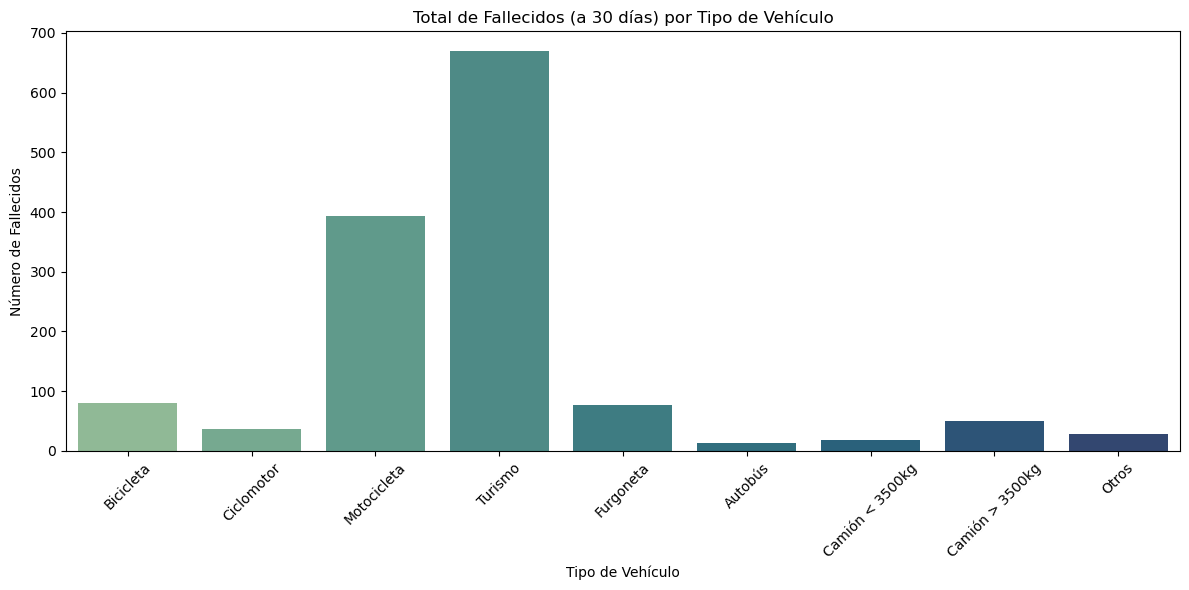

In [141]:
#Explorar el total de fallecidos de cada categoría
# Agrupar por categoría de vehículo (fallecidos a 30 días)
accidentes_por_categoria = {
    'Bicicleta': df_eda['TOT_BICI_MU30DF'].sum(),
    'Ciclomotor': df_eda['TOT_CICLO_MU30DF'].sum(),
    'Motocicleta': df_eda['TOT_MOTO_MU30DF'].sum(),
    'Turismo': df_eda['TOT_TUR_MU30DF'].sum(),
    'Furgoneta': df_eda['TOT_FURG_MU30DF'].sum(),
    'Autobús': df_eda['TOT_BUS_MU30DF'].sum(),
    'Camión < 3500kg': df_eda['TOT_CAM_MENOS3500_MU30DF'].sum(),
    'Camión > 3500kg': df_eda['TOT_CAM_MAS3500_MU30DF'].sum(),
    'Otros': df_eda['TOT_OTRO_MU30DF'].sum()
}

# Crear el DataFrame para graficar
df_acc_cat = pd.DataFrame(list(accidentes_por_categoria.items()), columns=['Categoría_Accidente', 'Num_Fallecidos'])

# Configurar el layout y graficar
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_acc_cat, x='Categoría_Accidente', y='Num_Fallecidos', palette='crest')

# Títulos y etiquetas
ax.set_title('Total de Fallecidos (a 30 días) por Tipo de Vehículo')
ax.set_xlabel('Tipo de Vehículo')
ax.set_ylabel('Número de Fallecidos')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Se observa que los vehículos con mayor número de fallecidos son los turismos, con un total de 681 víctimas registradas, seguido de los motoristas, con 401 víctimas. Esto puede indicar que, aunque los turismos son comúnmente considerados más seguros que los vehículos de dos ruedas, la gran cantidad de conductores y pasajeros de turismos en circulación podría influir en el número elevado de fallecidos.

Por otro lado, los conductores y pasajeros de bicicletas representan una cifra significativa, con 81 víctimas, lo que destaca la vulnerabilidad de los ciclistas en las vías. Los ciclomotoristas, con 36 víctimas, también forman parte de este grupo vulnerable, aunque en menor proporción en comparación con los motoristas y ciclistas.

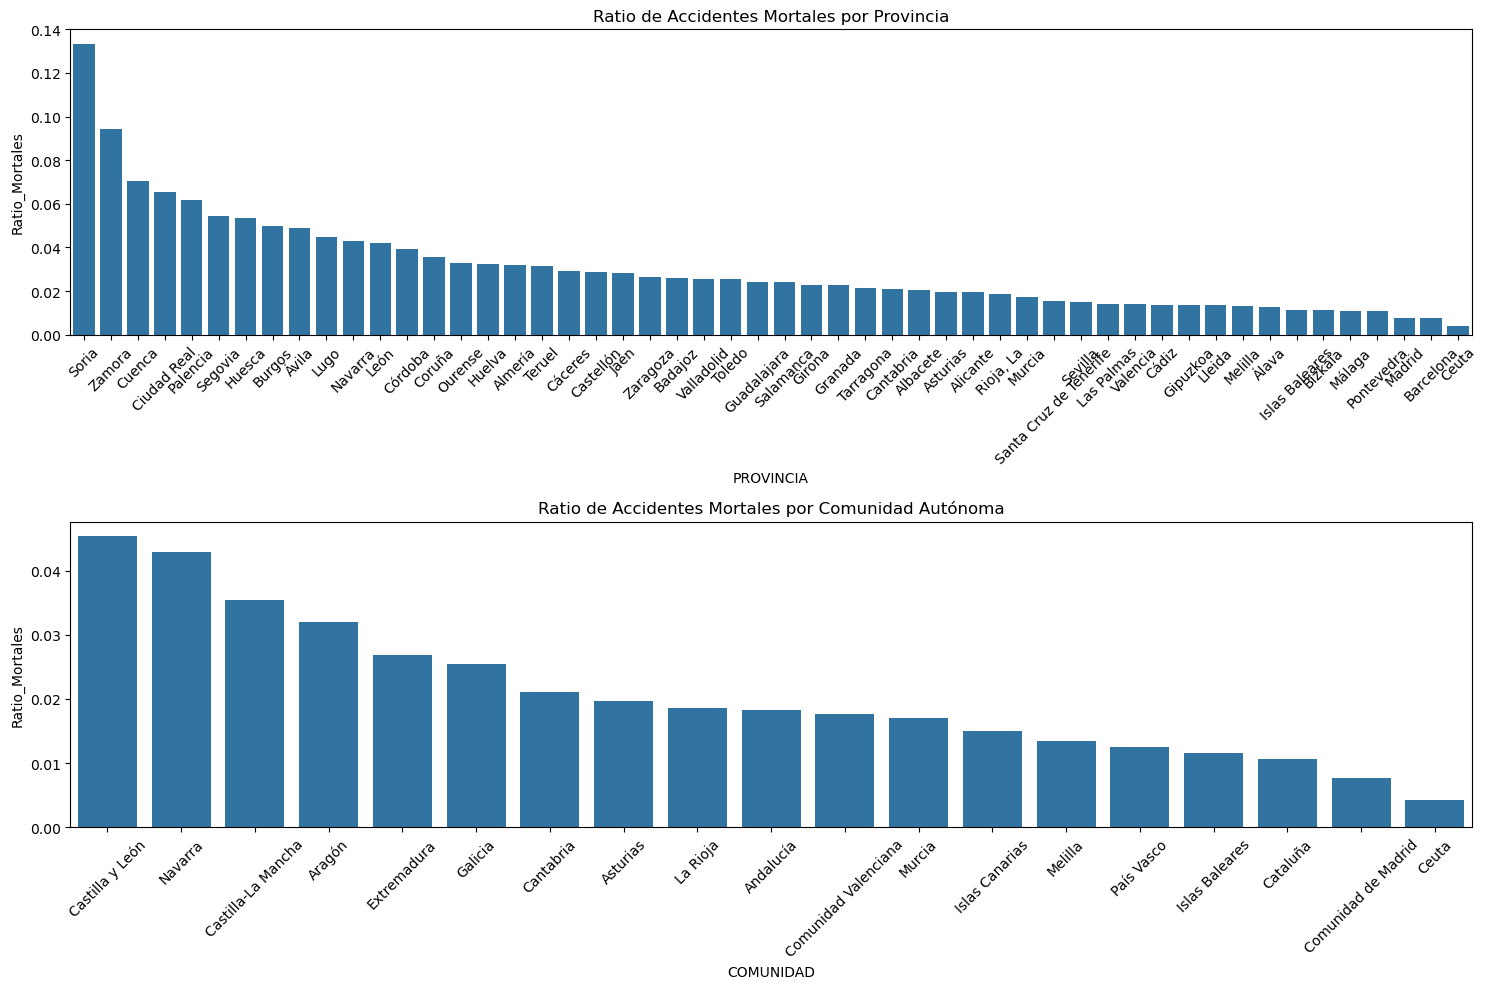

In [142]:
# Filtrar solo los accidentes mortales
df_mortal = df_eda[df_eda['TYP_ACC'] == 'Mortal']
# Agrupar por PROVINCIA y contar accidentes mortales
acc_prov = df_mortal.groupby('PROVINCIA').size().reset_index(name='Num_Accidentes_Mortales')
# Agrupar por PROVINCIA y contar todos los accidentes
acc_prov_total = df_eda.groupby('PROVINCIA').size().reset_index(name='Num_Accidentes_Totales')
# Unir ambos DataFrames
acc_prov = acc_prov.merge(acc_prov_total, on='PROVINCIA', how='left')
# Calcular el ratio de accidentes mortales
acc_prov['Ratio_Mortales'] = acc_prov['Num_Accidentes_Mortales'] / acc_prov['Num_Accidentes_Totales']
# Ordenar por ratio
acc_prov = acc_prov.sort_values('Ratio_Mortales', ascending=False)
# :diamante_azul_pequeño: Hacemos lo mismo por COMUNIDAD
acc_comun = df_mortal.groupby('COMUNIDAD').size().reset_index(name='Num_Accidentes_Mortales')
acc_comun_total = df_eda.groupby('COMUNIDAD').size().reset_index(name='Num_Accidentes_Totales')
# Unir ambos DataFrames
acc_comun = acc_comun.merge(acc_comun_total, on='COMUNIDAD', how='left')
# Calcular el ratio de accidentes mortales
acc_comun['Ratio_Mortales'] = acc_comun['Num_Accidentes_Mortales'] / acc_comun['Num_Accidentes_Totales']
# Ordenar por ratio
acc_comun = acc_comun.sort_values('Ratio_Mortales', ascending=False)
# Configurar el layout
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 1, figure=fig)
ax_provincia = fig.add_subplot(gs[0, 0])
ax_comunidad = fig.add_subplot(gs[1, 0])
# Graficar ratio de accidentes mortales por provincia
sns.barplot(ax=ax_provincia, data=acc_prov, x='PROVINCIA', y='Ratio_Mortales')
ax_provincia.set_title('Ratio de Accidentes Mortales por Provincia')
ax_provincia.tick_params(axis='x', rotation=45)
# Graficar ratio de accidentes mortales por comunidad autónoma
sns.barplot(ax=ax_comunidad, data=acc_comun, x='COMUNIDAD', y='Ratio_Mortales')
ax_comunidad.set_title('Ratio de Accidentes Mortales por Comunidad Autónoma')
ax_comunidad.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Conclusiones sobre provincias: Soria (13.3%), Zamora (9.4%), y Cuenca (7%) tienen los ratios más altos de accidentes mortales respecto al total de accidentes. Esto sugiere que, aunque quizás no tengan el mayor número absoluto de accidentes, la proporción de accidentes que resultan mortales es considerablemente alta. Ciudades grandes como Madrid (0.7%) y Barcelona (0.75%) tienen ratios mucho más bajos, lo que indica que, aunque tienen más accidentes en total, la proporción de accidentes mortales es menor (posiblemente por mejor infraestructura vial, sistemas de emergencia más eficientes o mayor cantidad de accidentes leves en comparación con provincias rurales).
Conclusiones sobre comunidades autónomas: Castilla y León (4.5%), Navarra (4.3%) y Castilla-La Mancha (3.5%) lideran con los ratios más altos de accidentes mortales. Esto sugiere que la peligrosidad en las carreteras de estas comunidades es relativamente mayor. Madrid (0.77%) y Cataluña (1%) tienen ratios bajos, similar a la tendencia vista en las provincias. Las ciudades con mayor tráfico tienen más accidentes totales, pero los accidentes mortales son menos frecuentes en proporción. Ceuta (0.4%) y Melilla (1.3%) son las que tienen los ratios más bajos, lo que podría deberse a su tamaño pequeño y menor número de carreteras de alto riesgo.
Posibles interpretaciones:
- Las zonas rurales o con menos densidad poblacional tienden a tener mayores ratios de accidentes mortales, posiblemente porque hay más carreteras secundarias, menos acceso rápido a hospitales y más velocidad en vías interurbanas.
- Las grandes ciudades tienen más accidentes en total, pero su proporción de accidentes mortales es baja, probablemente por mejores medidas de seguridad, regulación de tráfico más estricta y mayor infraestructura de emergencia.
- Las regiones con alta proporción de accidentes mortales podrían beneficiarse de políticas enfocadas en seguridad vial, como mejoras en carreteras, aumento de señalización o campañas de concienciación.

# Influencia de diversas variables en el tipo de accidente

Vamos a estudiar ahora la distribución del tipo de accidente en ciertas variables.

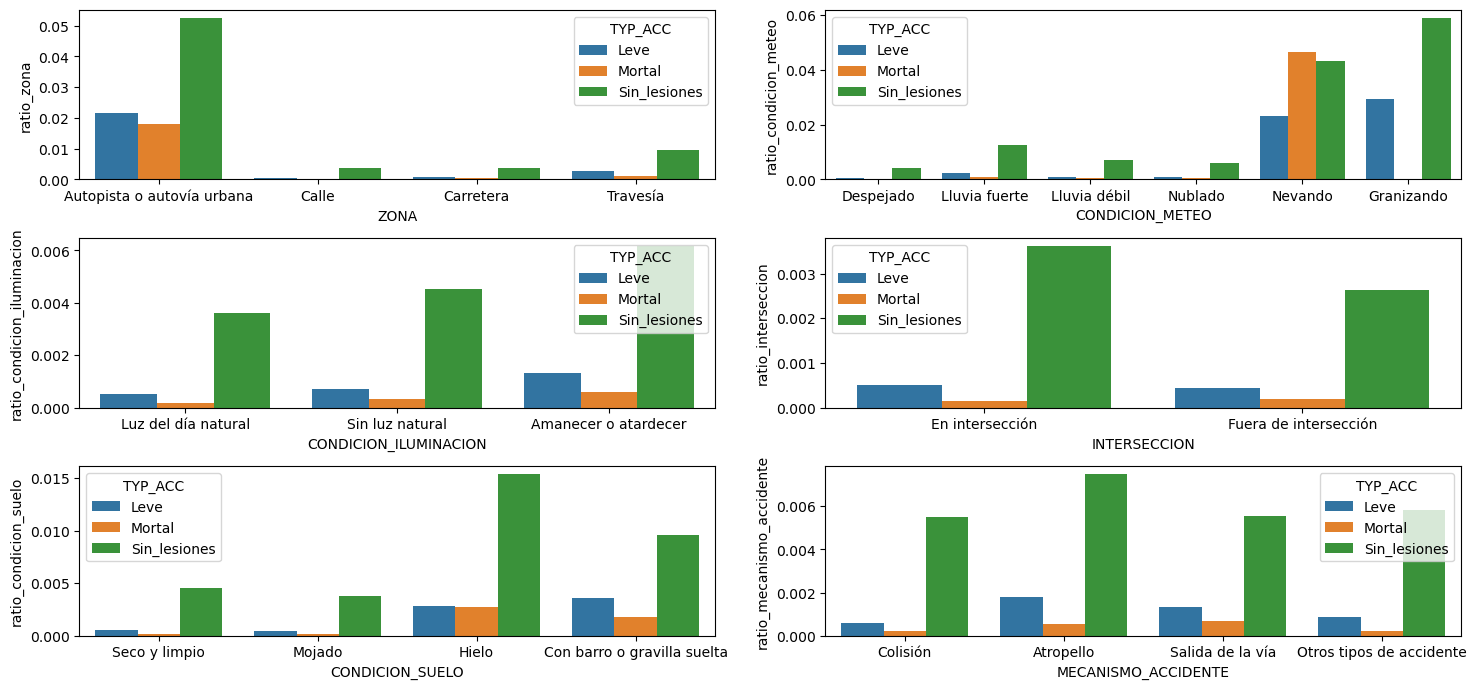

In [143]:
# Calcular conteos por variable y TYP_ACC
df_counts = df_eda.groupby(['ZONA', 'TYP_ACC', 'CONDICION_METEO', 'CONDICION_ILUMINACION','INTERSECCION','MECANISMO_ACCIDENTE',
                            'CONDICION_SUELO']).size().reset_index(name='count')

#Calcular el total de accidentes para cada categoría
df_counts['total_acc'] = df_counts.groupby('TYP_ACC')['count'].transform('sum')

for var in ['ZONA', 'CONDICION_METEO', 'CONDICION_ILUMINACION','INTERSECCION','MECANISMO_ACCIDENTE','CONDICION_SUELO']:
    df_counts['ratio_' + var.lower()] = df_counts['count'] / df_counts.groupby(var)['count'].transform('sum')

#Calcular el ratio de cada accidente para cada combinación
df_counts['ratio_acc'] = df_counts['count'] / df_counts['total_acc']

#Graficar
fig, axes = plt.subplots(3, 2, figsize=(15, 7))
sns.barplot(ax=axes[0,0], data=df_counts, x='ZONA', y='ratio_zona', hue='TYP_ACC', errorbar=None)
sns.barplot(ax=axes[0,1], data=df_counts, x='CONDICION_METEO', y='ratio_condicion_meteo', hue='TYP_ACC', errorbar=None)
sns.barplot(ax=axes[1,0], data=df_counts, x='CONDICION_ILUMINACION', y='ratio_condicion_iluminacion', hue='TYP_ACC', errorbar=None)
sns.barplot(ax=axes[1,1], data=df_counts, x='INTERSECCION', y='ratio_interseccion', hue='TYP_ACC', errorbar=None)
sns.barplot(ax=axes[2,0], data=df_counts, x='CONDICION_SUELO', y='ratio_condicion_suelo', hue='TYP_ACC', errorbar=None)
sns.barplot(ax=axes[2,1], data=df_counts, x='MECANISMO_ACCIDENTE', y='ratio_mecanismo_accidente', hue='TYP_ACC', errorbar=None)

plt.tight_layout()
plt.show()

Las gráficas muestran que los accidentes sin lesiones son los más frecuentes en todas las condiciones analizadas. En términos de zonas, las autopistas y autovías urbanas tienen una mayor incidencia de accidentes mortales y leves, aunque los accidentes sin lesiones siguen siendo mayoritarios. Las condiciones meteorológicas despejadas y con lluvia débil también muestran una alta frecuencia de accidentes sin lesiones, mientras que la condición meteorológica de 'Nevando' aumenta muchisimo la incidencia de accidentes mortales. La iluminación natural durante el día y las condiciones del suelo seco y limpio están asociadas con una mayor frecuencia de accidentes sin lesiones. En cuanto a los mecanismos de accidente, las colisiones y atropellos son los más comunes, predominando los accidentes sin lesiones en todos los casos.

En conclusión, los accidentes sin lesiones son predominantes en la mayoría de las condiciones analizadas, lo que sugiere que las medidas de seguridad y prevención deben enfocarse en reducir la frecuencia de estos accidentes, especialmente en zonas urbanas y bajo condiciones meteorológicas adversas. Además, es importante considerar la iluminación y el estado del suelo para mejorar la seguridad vial.

 # MACHINE LEARNING

In [144]:
# Lista de columnas a eliminar
columnas_a_eliminar = [
    'TOT_PEAT_MU30DF', 'TOT_BICI_MU30DF', 'TOT_CICLO_MU30DF', 'TOT_MOTO_MU30DF',
    'TOT_TUR_MU30DF', 'TOT_FURG_MU30DF', 'TOT_CAM_MENOS3500_MU30DF', 'TOT_CAM_MAS3500_MU30DF',
    'TOT_BUS_MU30DF', 'TOT_VMP_MU30DF', 'TOT_OTRO_MU30DF','TOTAL_HG24H', 'TOTAL_MU30DF', 'TOTAL_HG30DF',
       'TOTAL_HL30DF',
]
# Eliminar las columnas del DataFrame
df = df.drop(columns=columnas_a_eliminar)

La razón por la que se borran estas columnas es que las columnas que contienen el número de fallecidos por tipo de vehículo no aportan directamente a la predicción de la variable objetivo (TYP_ACC), ya que no describen el tipo de accidente como tal.

Se evita la redundancia, dado que ya tienes una columna general sobre muertes, agregar más columnas relacionadas con fallecidos por tipo de vehículo podría sobrecargar al modelo con datos redundantes.

Reducir ruido y prevenir sobreajuste: 
Incluir demasiadas columnas relacionadas puede confundir al modelo, haciendo que aprenda patrones poco generales, lo que lleva al sobreajuste.

Evitar fuga de datos (data leakage):

Las columnas como 'TOTAL_MU30DF' y 'TOTAL_HG24H' están directamente relacionadas con la gravedad del accidente y su tipo. Si incluyes estos datos en las características (X), el modelo aprenderá "por adelantado" la información que intenta predecir, causando una precisión perfecta irreal. Para que el modelo sea capaz de identificar patrones reales y generalizables, debe basarse en características independientes de la variable objetivo. Mantener estas columnas generaría ruido que afecta la interpretación y confiabilidad del modelo.

Evitar métricas distorsionadas:

Incluir estas columnas podría inflar artificialmente la precisión (accuracy) porque estarías dándole al modelo pistas explícitas sobre la etiqueta correcta, lo cual va en contra del propósito del aprendizaje automático.

A continuación; se procede a la factorización de ciertas columnas del dataframe.

Factorizamos los valores categóricos para mejorar la interpretación y el rendimiento del modelo. La factorización convierte las categorías en números enteros, lo que facilita el procesamiento por parte de algoritmos como árboles de decisión y random forest. Esto reduce la complejidad del modelo y asegura que las comparaciones entre categorías sean consistentes. Además, permite al modelo manejar los datos de manera más eficiente y realizar predicciones más precisas.


In [145]:
#factorizamos primero 
df['TYP_ACC'] = df['TYP_ACC'].map({'Mortal': 2, 'Leve': 1, 'Sin_lesiones': 0}) #en orden de importancia de más a menos
df['CARRETERA'] = pd.factorize(df['CARRETERA'])[0]
df['COMUNIDAD'] = pd.factorize(df['COMUNIDAD'])[0]

Una vez factorizados los valores categóricos, se llevará a cabo un oversampling para aumentar las muestras de los accidentes graves y leves utilizando el método SMOTE (Synthetic Minority Over-sampling Technique). SMOTE genera muestras sintéticas para las clases minoritarias, incrementando así el número de muestras de esas clases. Esto ayuda a balancear el dataset, permitiendo que el modelo de machine learning tenga suficientes datos para aprender sobre ambas clases de manera efectiva, mejorando así su rendimiento y precisión en la predicción de accidentes graves y leves.

Con un dataset balanceado, el modelo será más capaz de predecir accidentes mortales y leves, que inicialmente estaban subrepresentados. Esto es especialmente importante en aplicaciones donde la detección de accidentes graves es crítica.

In [146]:
# resampling

X = df.drop(['TYP_ACC'], axis=1)
y = df['TYP_ACC']

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.Series(y_resampled, name='TYP_ACC')], axis=1)

print("Distribución tras SMOTE:")
print(df_resampled['TYP_ACC'].value_counts())

Distribución tras SMOTE:
TYP_ACC
1    87060
0    87060
2    87060
Name: count, dtype: int64


SMOTE ha logrado balancear el dataset (inicialmente altamente desequilibrado), igualando el número de muestras para cada tipo de accidente. Esto es crucial para mejorar el rendimiento del modelo de machine learning (modelo más robusto y preciso), ya que ahora tiene suficientes datos para aprender sobre cada clase de accidente de manera efectiva.

Al tener un número igual de muestras para cada clase, se reduce el sesgo hacia la clase mayoritaria (accidentes sin lesiones), permitiendo que el modelo trate todas las clases de manera equitativa.


Ahora que los datos están igualados podemos seleccionar los mejores features y dividir los datos y comenzar con el entrenamiento de los modelos.

In [147]:
#Seleccionar los mejores features basados en ANOVA
# Seleccionamos las 6 mejores
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Mejores features:", selected_features)

Mejores features: Index(['DIA_SEMANA', 'HORA', 'ZONA', 'CARRETERA', 'MECANISMO_ACCIDENTE',
       'TOTAL_VICTIMAS_30DF', 'TOTAL_VEHICULOS', 'INTERSECCION',
       'CONDICION_ILUMINACION', 'COMUNIDAD'],
      dtype='object')


Se ha utilizado la técnica de selección de características basada en ANOVA (Analysis of Variance) para identificar las características más relevantes para predecir la variable objetivo. Esto se hace para mejorar el rendimiento del modelo de machine learning, reduciendo la dimensionalidad del dataset y eliminando características irrelevantes o redundantes. Al seleccionar solo las características más importantes, se mejora la eficiencia y precisión del modelo, permitiendo que aprenda de manera más efectiva y generalice mejor en nuevos datos.

In [148]:
#Convertir la hora en un reloj cíclico
df_resampled['HORA_sin'] = np.sin(2 * np.pi * df_resampled['HORA'] / 24)
df_resampled['HORA_cos'] = np.cos(2 * np.pi * df_resampled['HORA'] / 24)

In [149]:
# he probado a reducir las variables, con esto se puede jugar para ver como afecta a la precision
num_variables = ['MES', 'DIA_SEMANA', 'COD_PROVINCIA', 'ZONA',
       'MECANISMO_ACCIDENTE', 'TOTAL_VICTIMAS_30DF', 'TOTAL_VEHICULOS',
       'INTERSECCION', 'CONDICION_METEO','HORA_cos','HORA_sin','CARRETERA']

X = df_resampled.drop("TYP_ACC", axis = 1)[num_variables]
y = df_resampled["TYP_ACC"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Tras mucho ensayo de prueba y error se considera que estas variables son las que mejor maximizan la precisión del modelo

In [150]:
#Por último, vamos a además a darle más peso a 'grave' y 'leve'para que el modelo las de más importancia
manual_class_weights = {0: 1.0, 1: 2.0, 2: 3.0}

ÁRBOL DE DECISIÓN

In [151]:
model_tree = DecisionTreeClassifier(random_state = 42,class_weight=manual_class_weights)
model_tree.fit(X_train, y_train)

y_pred_tree = model_tree.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print ("El Accuracy del modelo Árbol de decisión es:",accuracy_tree)

El Accuracy del modelo Árbol de decisión es: 0.870529902749062


RANDOM FOREST

In [152]:
model_random= RandomForestClassifier(random_state = 42,class_weight=manual_class_weights)
model_random.fit(X_train, y_train)

y_pred_rf = model_random.predict(X_test)
accuracy_random = accuracy_score(y_test, y_pred_rf)
print ("El Accuracy del modelo Random forest es:",accuracy_random)

El Accuracy del modelo Random forest es: 0.9050271843173291


El modelo de random forest tiene una precisión significativamente mayor en comparación con el árbol de decisión. Esto indica que el random forest es más efectivo para capturar las relaciones complejas en los datos y hacer predicciones más precisas.
Robustez: El random forest es menos propenso al sobreajuste, lo que lo hace más confiable para datos nuevos y no vistos. Esto se debe a que combina múltiples árboles de decisión, reduciendo la variabilidad y mejorando la estabilidad del modelo.
Interpretabilidad: Aunque el árbol de decisión es más fácil de interpretar, el random forest ofrece una mejor precisión y robustez, lo que puede ser más valioso en aplicaciones donde la precisión es crítica.

En resumen, aunque el árbol de decisión es útil para obtener una comprensión inicial de los datos y las relaciones entre las variables, el modelo de random forest es superior en términos de precisión y robustez. 


Se decide emplear XGBoost debido a su capacidad para manejar datasets grandes y complejos de manera eficiente. XGBoost utiliza el algoritmo de gradient boosting, que crea un conjunto de árboles de decisión donde cada árbol corrige los errores del anterior, resultando en un modelo muy preciso. Además, XGBoost ofrece una gran flexibilidad en la configuración de hiperparámetros, lo que permite optimizar el rendimiento del modelo. Su capacidad para manejar datos desequilibrados y su robustez en la predicción de clases minoritarias lo hacen una opción ideal para mejorar la precisión y eficiencia de nuestro modelo de machine learning.


XGBOOST


In [153]:
# Crear y entrenar el modelo XGBoost
model_xgb = xgb.XGBClassifier(random_state=42,class_weight=manual_class_weights)
model_xgb.fit(X_train, y_train)

# Hacer predicciones y calcular la precisión
y_pred_xgb = model_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print ("El Accuracy del modelo XGBoost es:",accuracy_xgb)

c:\Users\Carlos\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


El Accuracy del modelo XGBoost es: 0.7339765678842178


Matriz de confusión de los tres modelos de Machine Learning empleados

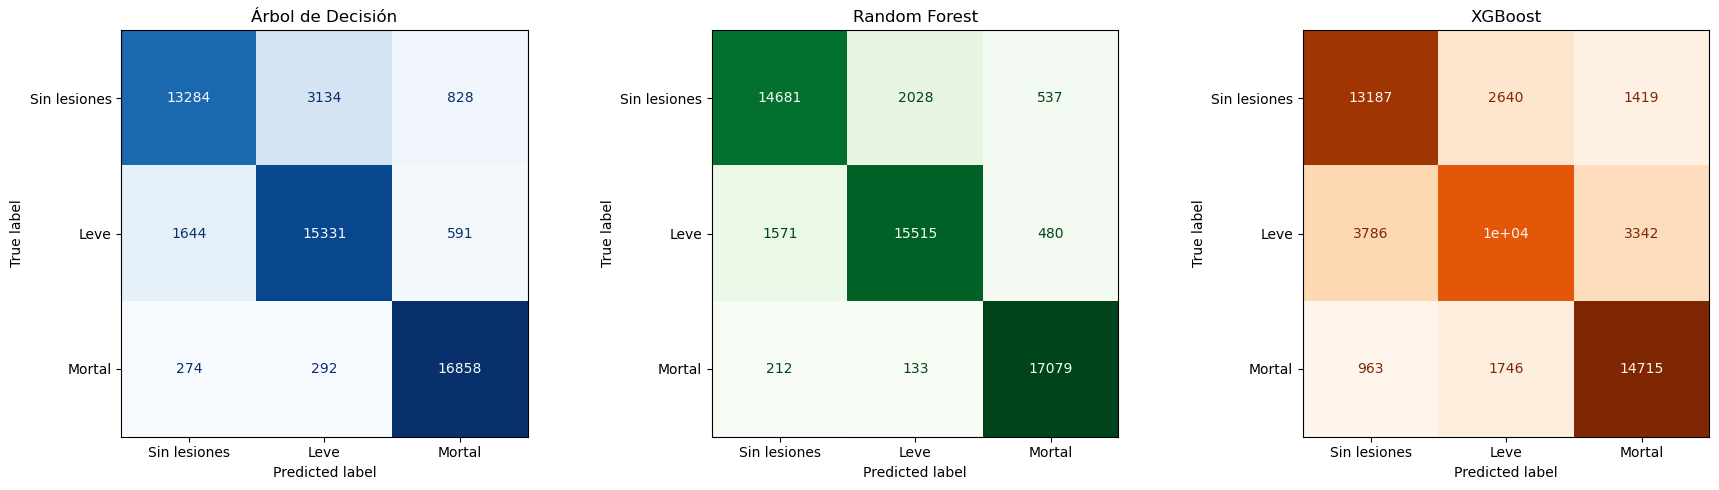

In [154]:
# Etiquetas de las clases (ajusta según tu problema)
etiquetas = ['Sin lesiones', 'Leve', 'Mortal']

# Calcular matrices
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Crear figura con 3 subplots en una fila
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Árbol de Decisión
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=etiquetas)
disp_tree.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
axes[0].set_title('Árbol de Decisión')

# Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=etiquetas)
disp_rf.plot(ax=axes[1], cmap=plt.cm.Greens, colorbar=False)
axes[1].set_title('Random Forest')

# XGBoost
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=etiquetas)
disp_xgb.plot(ax=axes[2], cmap=plt.cm.Oranges, colorbar=False)
axes[2].set_title('XGBoost')

plt.tight_layout()
plt.show()

Árbol de Decisión:

Tiene un buen rendimiento en general, especialmente en la clasificación de la clase "Mortal", pero presenta algunas dificultades para clasificar correctamente "Leve" y "Sin lesiones". Su desempeño es bastante equilibrado entre las tres clases.

Random Forest:

Es el modelo con el mejor rendimiento en general, con las tasas más altas de TP en las tres clases. Tiene muy pocas malas clasificaciones, especialmente en la clase "Mortal", lo que lo convierte en el modelo más robusto de los tres.

Su rendimiento en la clasificación de "Sin lesiones" y "Mortal" es especialmente fuerte.

XGBoost:

Este modelo tiene un rendimiento inferior al Árbol de Decisión y al Random Forest, especialmente en la clase "Leve", donde hay una mayor cantidad de confusión.

Aunque tiene un rendimiento razonable en la clasificación de "Mortal", la clasificación de "Sin lesiones" y "Leve" no es tan precisa como en los otros dos modelos.

Conclusiones:
Random Forest parece ser el mejor modelo en términos de precisión global, con el menor número de malas clasificaciones.

XGBoost tiene un rendimiento un poco inferior en comparación con los otros dos modelos, por lo que podría ser interesante seguir ajustando los hiperparámetros o explorar diferentes técnicas para mejorar su rendimiento.

El análisis de la matriz de confusión, se observa cómo se comporta tu modelo en términos de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos. Sin embargo, la matriz de confusión por sí sola no proporciona toda la información necesaria para evaluar la calidad del modelo de manera completa. Solo te dice cuántos casos fueron clasificados correctamente o incorrectamente, pero no te proporciona información detallada sobre el tipo de error que el modelo está cometiendo.


Por eso, es necesario analizar otros parámetros que se derivan de ella, tales como: Precision, recall, F1-Score, etc...


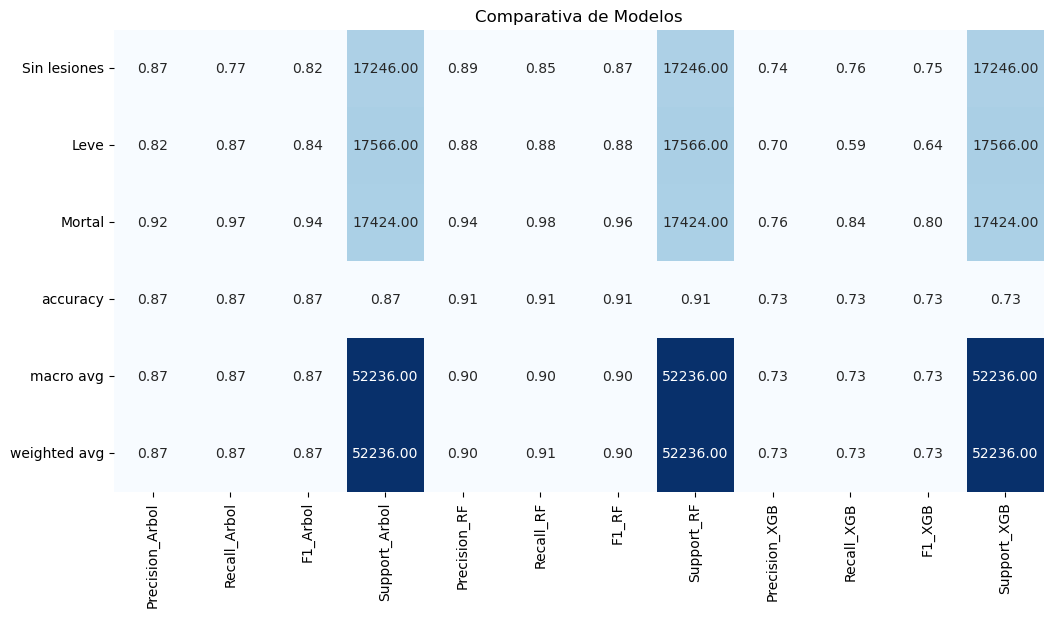

In [155]:
# Generar reportes
report_tree = classification_report(y_test, y_pred_tree, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)

# Convertir a DataFrame
report_tree_df = pd.DataFrame(report_tree).T
report_rf_df = pd.DataFrame(report_rf).T
report_xgb_df = pd.DataFrame(report_xgb).T


# Cambiar los índices solo para las primeras 3 filas, que corresponden a las clases
report_tree_df.index = ['Sin lesiones', 'Leve', 'Mortal'] + report_tree_df.index[3:].tolist()
report_rf_df.index = ['Sin lesiones', 'Leve', 'Mortal'] + report_rf_df.index[3:].tolist()
report_xgb_df.index = ['Sin lesiones', 'Leve', 'Mortal'] + report_xgb_df.index[3:].tolist()

# Concatenamos los DataFrames
report_df = pd.concat([report_tree_df, report_rf_df, report_xgb_df], axis=1)

# Asignar nombres a las columnas
report_df.columns = ['Precision_Arbol', 'Recall_Arbol', 'F1_Arbol', 'Support_Arbol', 
                     'Precision_RF', 'Recall_RF', 'F1_RF', 'Support_RF', 
                     'Precision_XGB', 'Recall_XGB', 'F1_XGB', 'Support_XGB']

# Visualizar el reporte
plt.figure(figsize=(12, 6))
sns.heatmap(report_df, annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title("Comparativa de Modelos")
plt.show()

Random Forest es el modelo que ofrece el mejor rendimiento en términos de precisión, recall, F1-Score y exactitud. Es capaz de clasificar correctamente las tres clases con una alta tasa de precisión y recall, especialmente en la clase "Mortal".

Árbol de Decisión: Aunque tiene un buen desempeño general, su rendimiento es inferior en comparación con Random Forest, especialmente en la clase "Leve". Sin embargo, sigue siendo una opción sólida, especialmente si se busca un modelo más sencillo.

XGBoost: Aunque es un modelo poderoso, en este caso específico no ha sido tan efectivo como los otros dos. Su desempeño en la clase "Leve" es particularmente bajo, lo que sugiere que este modelo podría necesitar ajustes adicionales para mejorar su rendimiento.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
} 

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5,
                           scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best hyperparametes:", grid_search.best_params_)
print("Validation Score:", grid_search.best_score_)

Los parámetros se estuvieron optimizando por más de 8 horas sin resultados por lo que se optó por detenerlos, dado el tamaño de nuestro modelo, que ya tenemos una precision aceptable, y el tiempo del que se dispone para este proyecto consideramos que no es viable seguir tratando de optimizar los parámetros.

# ANN

Por último, vamos a comprobar si un modelo de Deep Learning puede mejorar los anteriores, utilizaremos un modelo de Artificial Neural Network (ANN) que aunque no haya sido parte del contenido del curso si que se ha mencionado brevemente y consideramos que puede hacer un buen desempeño en este problema.

Vamos también a mejorar el tratamiento de las variables. En principio los modelos empleados anteriormente no tienen problemas al trabajar con variables categóricas en forma numérica, es decir no interpreta que 2 es mayor que 1 y que son equidistantes de 3 y 4, ya que estos números solo señalan categorías, no obstante ANN si podría hacer esta interpretación generando dificultades en su aprendizaje. Para solventarlo y dado que nuestras variables tienen pocas categorías, vamos a usar el método de One-hot Encoding, con este método se creará una columna para cada categoría de cada variable, es decir, la variable 'DIA_SEMANA' que contiene los 7 días de la semana ahora pasará a ser 7 columnas todas ellas con ceros y unos en función de si el accidente ocurrió ese día o no, esto aumentará el tamaño del dataset, pero como ya he mencionado las variables tienen pocas categorías, asique debería ser un incremento asumible.

Por último, dividiremos la hora en dos columnas seno y coseno para crear un reloj circular y que la hora 23:00 esté a la misma distancia de las 00:00 de lo que la 01:00 lo está de las 02:00

In [ ]:
#Aplicar One-hot Encoding
cols_to_encode = ['MES', 'DIA_SEMANA', 'HORA', 'COD_PROVINCIA', 'ZONA',
       'MECANISMO_ACCIDENTE', 'TOTAL_VICTIMAS_30DF', 'TOTAL_VEHICULOS',
       'INTERSECCION', 'CONDICION_METEO', 'COMUNIDAD']
df_dummies = pd.get_dummies(df_resampled[['MES','CONDICION_METEO','COD_PROVINCIA','MECANISMO_ACCIDENTE','COMUNIDAD','ZONA','DIA_SEMANA','INTERSECCION']])
df_final = pd.concat([df_dummies, df_resampled[['TYP_ACC','TOTAL_VEHICULOS','HORA_cos','HORA_sin','TOTAL_VICTIMAS_30DF','CARRETERA']]], axis=1)

X_final = df_final.drop("TYP_ACC", axis = 1)
y_final = df_final["TYP_ACC"]

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size = 0.2, random_state = 42)

In [ ]:
# Escalar los datos, ya que no lo hicimos anteriormente
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final  = scaler.transform(X_test_final)

# Definimos una arquitectura de 3 capas
num_features = X_train_final.shape[1]      # Número de variables predictoras
num_classes = len(np.unique(y_train_final))  # Número de clases

model_ann = Sequential([
    Dense(128, activation='relu', input_dim=num_features),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax') #Capa de salida con el mismo número de neuronas que clases de accidentes
])

model_ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Establecemos un earlystop que detendrá el entrenamiento si no se producen mejoras
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo 
history = model_ann.fit(X_train_final, y_train_final, epochs=50, batch_size=64,
                    validation_split=0.2, callbacks=[early_stop])

loss, accuracy = model_ann.evaluate(X_test_final, y_test_final)
print("Test accuracy:", accuracy)

Epoch 1/50


c:\Users\Carlos\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2612/2612 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4990 - loss: 1.0237 - val_accuracy: 0.5678 - val_loss: 0.8767
Epoch 2/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5520 - loss: 0.9037 - val_accuracy: 0.5773 - val_loss: 0.8583
Epoch 3/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5625 - loss: 0.8875 - val_accuracy: 0.5853 - val_loss: 0.8453
Epoch 4/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5692 - loss: 0.8769 - val_accuracy: 0.5907 - val_loss: 0.8344
Epoch 5/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5703 - loss: 0.8740 - val_accuracy: 0.5948 - val_loss: 0.8305
Epoch 6/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5783 - loss: 0.8657 - val_accuracy: 0.5986 - val_loss: 0.8234
Epoch 7/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5783 - loss: 0.8626 - val_accuracy: 0.5990 - val_loss: 0.8200
Epoch 8/50
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5816 - loss: 0.8592 - val_accur

1633/1633 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step
Matriz de Confusión:
 [[12202  2424  2620]
 [ 4716  6353  6497]
 [ 1545  1615 14264]]


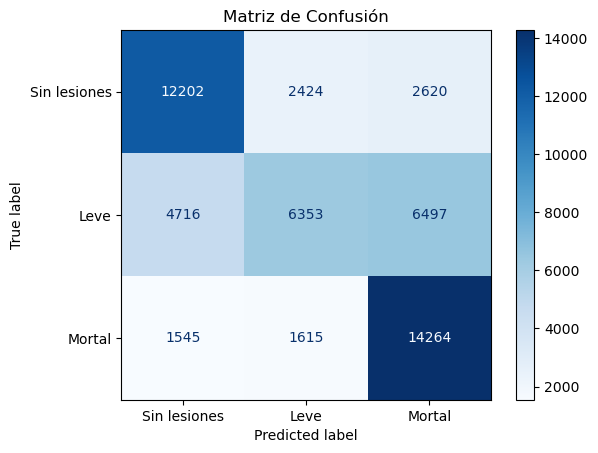

F1 Score (weighted): 0.6116654986925245


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

y_pred_probs = model_ann.predict(X_test_final)
# Convertir probabilidades a la clase predicha (índice con mayor probabilidad)
y_pred_ann = np.argmax(y_pred_probs, axis=1)

# Calculamos la matriz de confusión comparando las etiquetas verdaderas y_test_final con las predicciones y_pred_ann
cm = confusion_matrix(y_test_final, y_pred_ann)
print("Matriz de Confusión:\n", cm)

etiquetas = ['Sin lesiones', 'Leve', 'Mortal']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etiquetas)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

# Calculamos el F1 score utilizando el promedio ponderado
f1 = f1_score(y_test_final, y_pred_ann, average='weighted')
print("F1 Score (weighted):", f1)

Como se puede ver en la matriz a pesar el bajísimo rendimiento en términos de accuracy, incluso de de F1 Score, no obtante el modelo es relativamente bueno prediciendo los casos de accidentes 'Sin_lesiones' y accidente 'Mortal', se confunde en los Leves, considerándolos a la mayoría como accidentes mortales, pero la proporción de de accidentes mortales predichos como sin lesiones y viceversa es relativamente baja.

En cualquier caso creo que ANN a pesar de ser prometedor por la enorme cantidad de datos que teníamos no parece ser el mejor modelo para este trabajo. Por supuesto se podría seguir optimizando el modelo, pero hasta hora en cada mejora solo hemos ganado unas décimas de precision, y teniendo en cuenta lo por debajo que está en comparación con los modelos de Machine Learning anteriormente entrenados y la "gran" cantidad de tiempo que requiere para ejecutarse consideramos que es mejor dejarlo aquí.

# CONCLUSIONES

### Conclusiones

- **Capacidad de las técnicas de Machine Learning:**  
  Las técnicas de Machine Learning han demostrado ser adecuadas para resolver el problema planteado de forma razonablemente precisa.

- **Rendimiento del modelo:**  
  De todos los modelos empleados en este proyecto, **Random Forest** obtuvo el mejor rendimiento global, alcanzando una precisión superior al 90% y destacándose en precisión, recall y F1 score en comparación con los otros modelos.

- **Comparación entre modelos complejos y simples:**  
  Los modelos más complejos, como **XGBoost** y **Redes Neuronales Artificiales (ANN)**, tuvieron un desempeño menor al observado en modelos más simples, como el **Árbol de Decisión**. Se plantea que el elevado tamaño del dataframe (261.000 filas) utilizado en el entrenamiento pudo haber contribuido a un mayor sobreajuste en los modelos complejos; sin embargo, se necesitarán pruebas adicionales para confirmar esta hipótesis.

- **De cara a seguir mejorando este proyecto se propoponen las siguientes líneas de trabajo:**  
  - **Optimización de modelos:** Aplicar técnicas de búsqueda de hiperparámetros para afinar aún más el rendimiento.  
  - **Ampliación de la muestra de datos:** Incluir datos de más años, en lugar de limitarse solo al 2022.  
  - **Evaluación robusta:** Implementar una validación cruzada estratificada para evaluar los modelos de manera más robusta y evitar el sobreajuste.


In [ ]:
#Guardar el mejor modelo
nombre_archivo = '../model/modelo_dgt_comprimido.pkl'
dump(model_random, nombre_archivo, compress=('lzma', 9))

print(f"Modelo guardado correctamente en '{nombre_archivo}' con compresión.")

Modelo guardado correctamente en '../model/modelo_dgt_comprimido.pkl' con compresión.
